In [1]:
import numpy as np
import os
import subprocess
import sys
import json
import matplotlib.pyplot as plt
import torch

## Using colab?

In [2]:
colab = False
token = ""
repo_owner = "esemsc-dda24"
repo_name = "PTL-PINNS"

In [3]:
if colab:

    def clone_repo(repo_owner: str, repo_name: str, token: str = None):
        """
        Clone a GitHub repo using a token. Token can be passed or taken from GITHUB_TOKEN env var.
        """
        token = token or os.getenv("GITHUB_TOKEN")
        if not token:
            raise ValueError("GitHub token not provided or found in environment variables.")

        url = f"https://{token}@github.com/{repo_owner}/{repo_name}.git"
        target_dir = repo_name

        if not os.path.exists(target_dir):
            try:
                subprocess.run(["git", "clone", url], check=True)
                print(f"Successfully cloned '{repo_name}'.")
            except subprocess.CalledProcessError as e:
                print(f"Error cloning repo: {e}")
        else:
            print(f"Directory '{target_dir}' already exists; skipping git clone.")

    clone_repo(repo_owner, repo_name, token)
    sys.path
    sys.path.append(f"/content/{repo_name}/")
    !pip install neurodiffeq > /dev/null 2>&1
    %cd /content/{repo_name}
    !ls
    !pip install -e .
    %cd ..

from ptlpinns.models import load, model, training
from ptlpinns.odes import forcing, equations, numerical

## Training equations

In [4]:
#conf = load.ptl_config("/content/PTL-PINNS/ptlpinns/models/train/config/overderdamped.yaml")
conf = load.ptl_config("config/overdamped.yaml")

# save log
os.makedirs(conf["experiment"], exist_ok = True)
with open(f'{conf["experiment"]}/training_log.json', 'w') as f:
    json.dump(conf, f)

# load values
N = conf["N"]
t_span = (0, conf["t_max"])
t_eval = np.linspace(t_span[0], t_span[1], N)
k, w_list, forcing_freq, forcing_coef = conf["k"], conf["w_list"], conf["forcing_freq"], conf["forcing_coef"]
ic_python_list, zeta_list, mu_list = conf["ic_python_list"], conf["zeta_list"], conf["mu_list"]
ic_list = [load.initial_condition(y1_0=ic[0], y2_0=ic[1]) for ic in ic_python_list]

In [5]:
# define forcing
forcing_list_numpy = [forcing.overdamped_2D(True, zeta_list[i], mu_list[i], w_list[i], forcing_freq[i], forcing_coef[i]) for i in range(k)]
forcing_list_torch = [forcing.overdamped_2D(False, zeta_list[i], mu_list[i], w_list[i], forcing_freq[i], forcing_coef[i]) for i in range(k)]

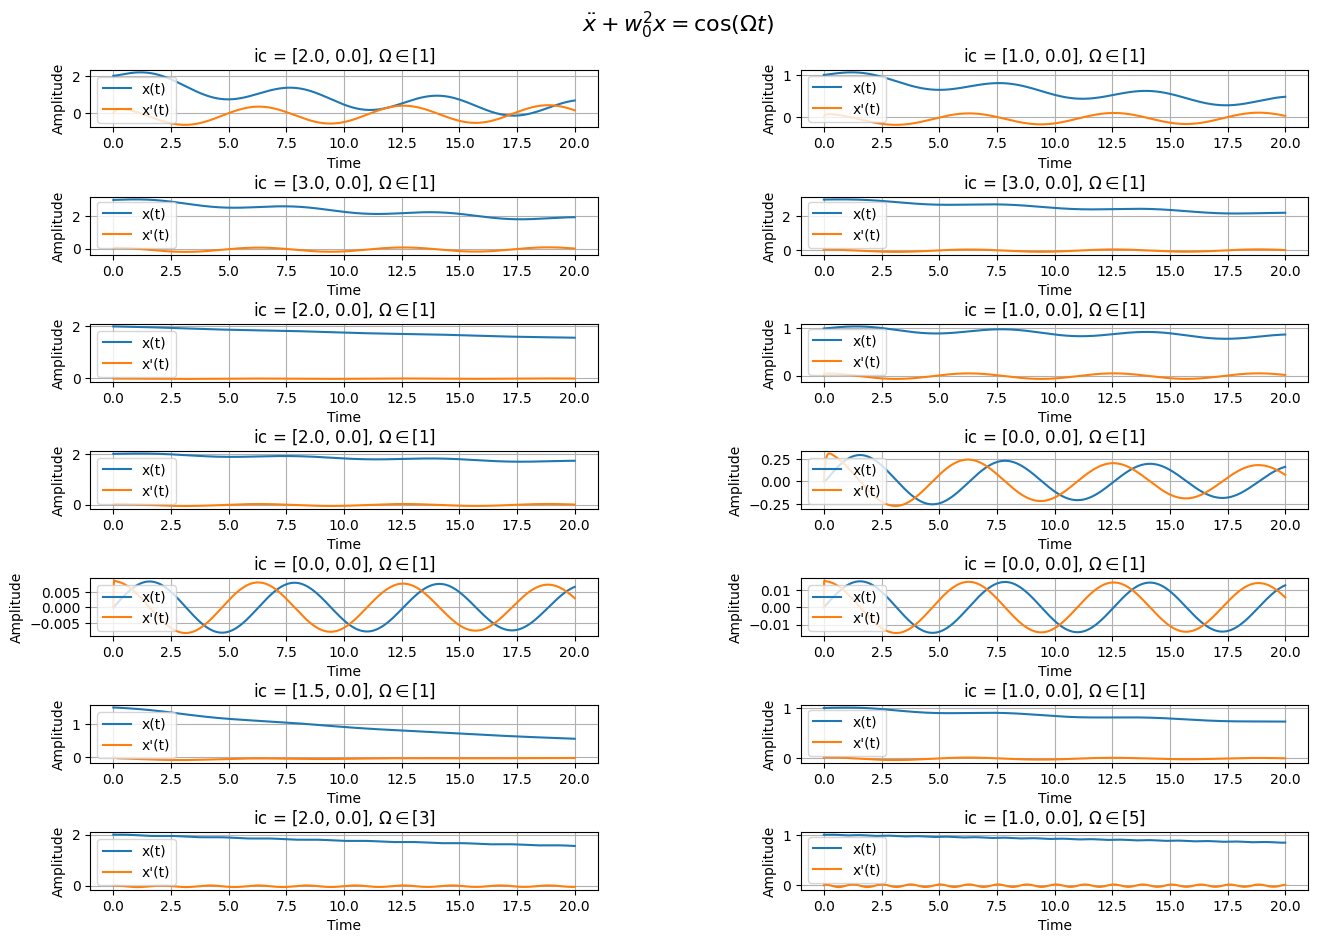

In [6]:
# returns 2D linear equation functions
linear_equation_functions_np = [equations.ode_oscillator(forcing_list_numpy[k],
                                                    w_0=w_list[k],
                                                    epsilon=0, zeta=zeta_list[k], numpy=True)
                                                    for k in range(k)]

# solves the 2D linear equation functions
title_list = [rf"ic = {ic_python_list[i]}, $\Omega \in {forcing_freq[i]}$"
              for i in range(k)]

linear_solution_list = [numerical.solve_ode_equation(linear_equation_functions_np[index], t_span, t_eval, ic_python_list[index]) for index in range(k)]

# visualize the solutions of the training equations
numerical.plot_multiple_ode_solutions(linear_solution_list,
                                       t_eval, titles=title_list,
                                       suptitle=r"$\ddot{x} + w^2_0 x = \cos(\Omega t)$", hspace = 1.2)

## Model Configuration

In [7]:
use_sine, use_fourier, n_frequencies, scale, bias = conf["use_sine"], conf["use_fourier"], conf["n_frequencies"], conf["scale"], conf["bias"]
hidden_layers, num_iter, learning_rate = conf["hidden_layers"], conf["num_iter"], conf["lr"]
step_size, gamma, method = conf["step_size"], conf["gamma"], conf["method"]
ode_weight, ic_weight = conf["w_ode"], conf["w_ic"]


# define model
pinn = model.Multihead_model_fourier(k, use_sine=use_sine, use_fourier=use_fourier, n_frequencies=n_frequencies,
                                      scale=scale, bias=bias, HIDDEN_LAYERS=hidden_layers)

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pinn.to(dev)

Multihead_model_fourier(
  (fourier): FourierFeatures()
  (linear1): SineLayer(
    (linear): Linear(in_features=32, out_features=128, bias=True)
  )
  (linear2): SineLayer(
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (final_layers): ModuleList(
    (0-13): 14 x Linear(in_features=128, out_features=1, bias=True)
  )
)

In [9]:
every=100
save_epoch=100
optimizer=torch.optim.Adam(pinn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

## Train Neural Network on Linear version

In [10]:
equation_functions = []
for i in range(k):
    equation_functions.append(equations.equation_oscillator(w_0=w_list[i], epsilon=0, zeta=zeta_list[i]))

In [11]:
loss_trace, ode_trace, ic_trace, result_trace = training.train(model=pinn, optimizer=optimizer, num_iter=num_iter, equation_functions=equation_functions,
                                                      initial_condition_functions=ic_list, forcing_functions=forcing_list_torch,
                                                      N=N, t_span=t_span, every=every, save_epoch=save_epoch, ode_weight=ode_weight,
                                                      ic_weight=ic_weight, scheduler=scheduler, method=method)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### View results and save

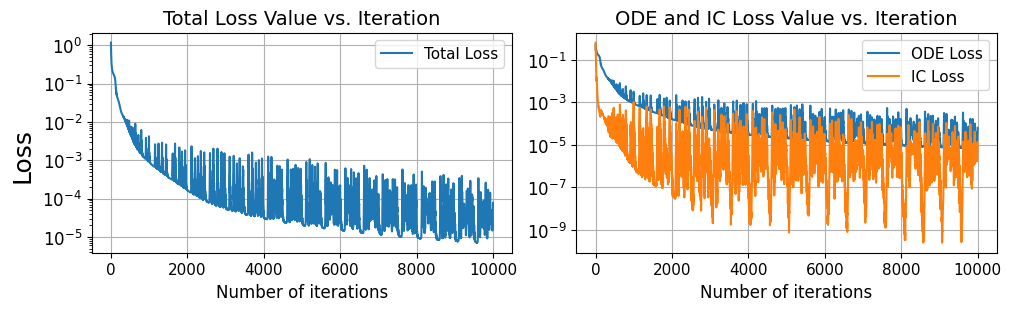

In [ ]:
training.plot_loss(loss_trace, ode_trace, ic_trace, path=None)

In [ ]:
# compute the NN solutions
pinn.eval()
pinn.to('cpu')
NN_solution, _ = pinn(training.generate_eval_tensor(N=N, t_span=t_span, require_grad=False))
NN_solution = NN_solution.detach().numpy()

name = conf["experiment"]
torch.save(pinn.state_dict(), f"/content/PTL-PINNS/ptlpinns/models/train/{name}/model_{name}.pth")

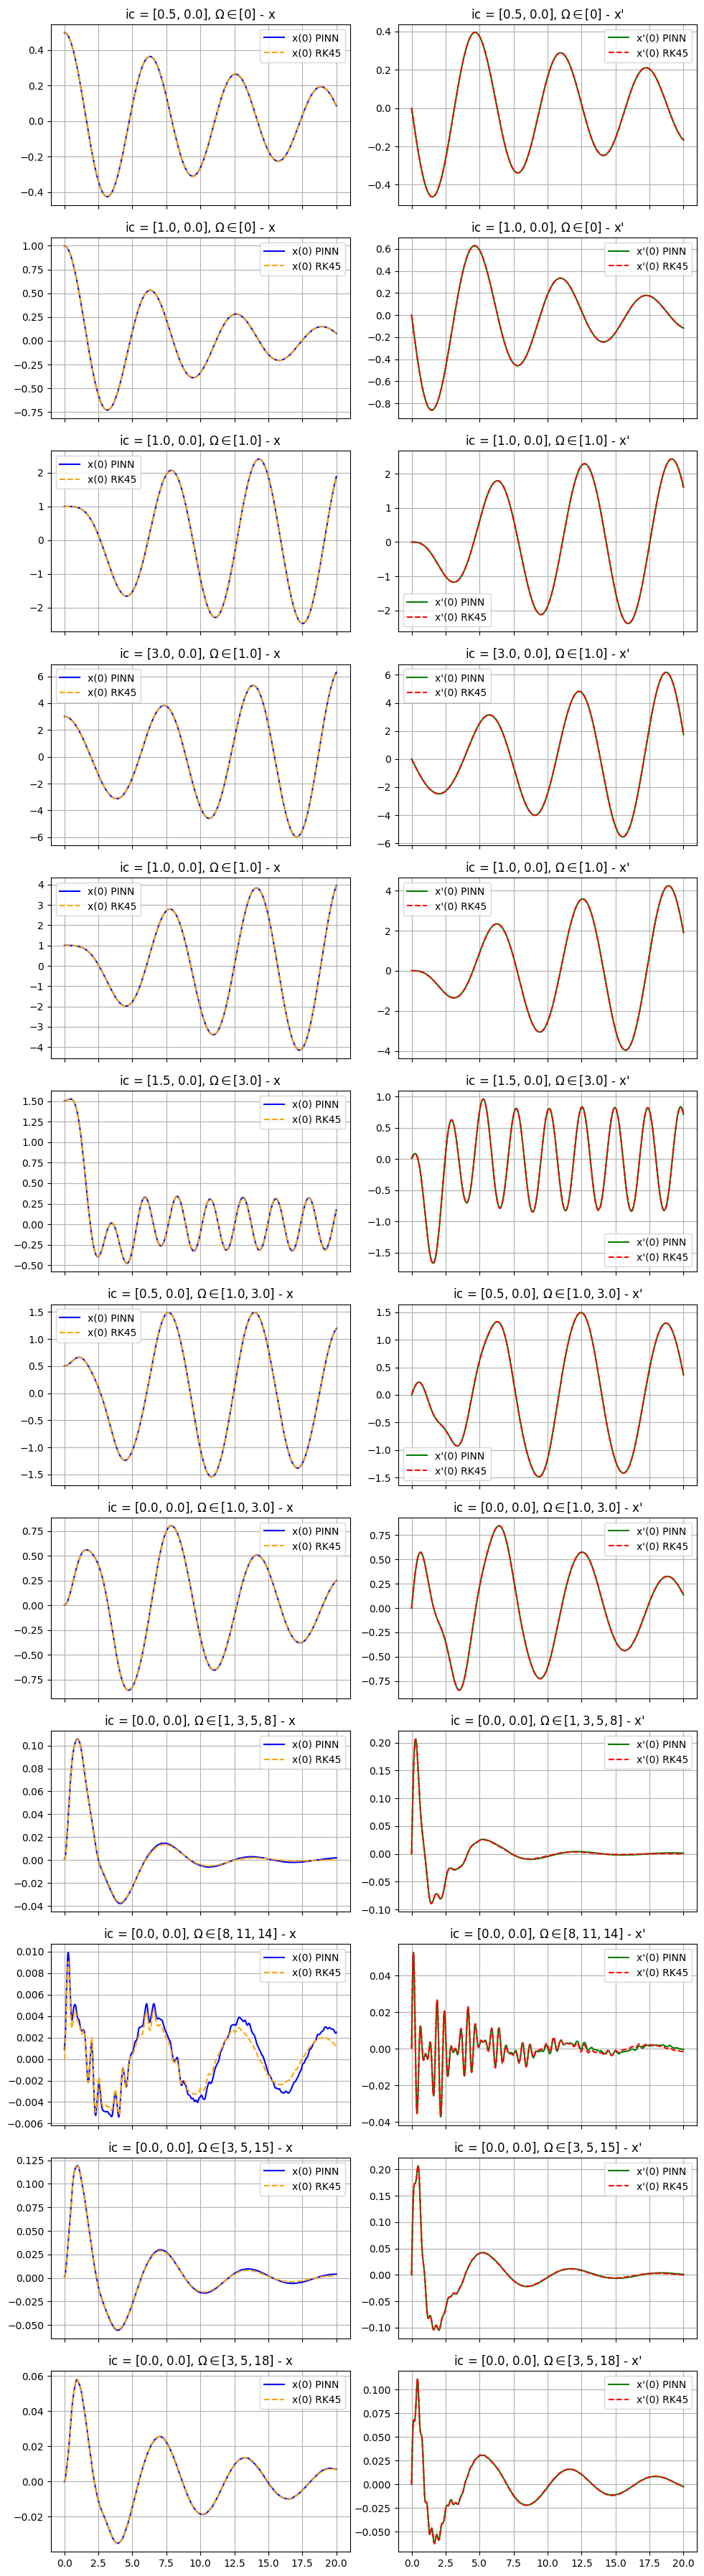

In [ ]:
training.compare_training_solutions(NN_solution, linear_solution_list, t_eval, title_list, k)